# Visium in SpatialData

This notebook is configured for a local SpatialData archive downloaded from the scverse docs. It extracts the bundled `data.zarr` store into a repo-local cache and then opens it with `spatialdata.read_zarr()`.

Configured archive: `/Users/chrislangseth/Downloads/visium_spatialdata_0.7.1.zip`

In [1]:
from pathlib import Path
import os
import zipfile
from pprint import pprint

import pandas as pd
import spatialdata as sd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
ZIP_PATH = Path(os.environ.get("SPATIALDATA_ZIP_PATH", "/Users/chrislangseth/Downloads/visium_spatialdata_0.7.1.zip"))
EXTRACT_ROOT = Path(os.environ.get("SPATIALDATA_EXTRACT_ROOT", "/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_spatialdata_0_7_1"))
ZARR_PATH = EXTRACT_ROOT / "data.zarr"

ZIP_PATH, EXTRACT_ROOT, ZARR_PATH

(PosixPath('/Users/chrislangseth/Downloads/visium_spatialdata_0.7.1.zip'),
 PosixPath('/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_spatialdata_0_7_1'),
 PosixPath('/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_spatialdata_0_7_1/data.zarr'))

In [3]:
if not ZIP_PATH.exists():
    raise FileNotFoundError(f"Archive not found: {ZIP_PATH}")

EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)

if not ZARR_PATH.exists():
    with zipfile.ZipFile(ZIP_PATH) as zf:
        members = [name for name in zf.namelist() if name.startswith("data.zarr/")]
        if not members:
            raise ValueError(f"Archive does not contain data.zarr/: {ZIP_PATH}")
        zf.extractall(EXTRACT_ROOT, members=members)
        print(f"Extracted {len(members)} members to {EXTRACT_ROOT}")
else:
    print(f"Using existing extracted store: {ZARR_PATH}")

sdata = sd.read_zarr(ZARR_PATH)

for table in sdata.tables.values():
    table.var_names_make_unique()

sdata

Extracted 386 members to /Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_spatialdata_0_7_1


SpatialData object, with associated Zarr store: /Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_spatialdata_0_7_1/data.zarr
├── Images
│     ├── 'ST8059048_hires_image': DataArray[cyx] (3, 2000, 1969)
│     ├── 'ST8059048_lowres_image': DataArray[cyx] (3, 600, 591)
│     ├── 'ST8059050_hires_image': DataArray[cyx] (3, 2000, 1968)
│     └── 'ST8059050_lowres_image': DataArray[cyx] (3, 600, 590)
├── Shapes
│     ├── 'ST8059048': GeoDataFrame shape: (2987, 2) (2D shapes)
│     └── 'ST8059050': GeoDataFrame shape: (3497, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (6484, 31053)
with coordinate systems:
    ▸ 'ST8059048', with elements:
        ST8059048_hires_image (Images), ST8059048 (Shapes)
    ▸ 'ST8059050', with elements:
        ST8059050_hires_image (Images), ST8059050 (Shapes)

In [4]:
summary = {
    "images": list(sdata.images),
    "labels": list(sdata.labels),
    "points": list(sdata.points),
    "shapes": list(sdata.shapes),
    "tables": list(sdata.tables),
}

pprint(summary)

{'images': ['ST8059048_hires_image',
            'ST8059048_lowres_image',
            'ST8059050_hires_image',
            'ST8059050_lowres_image'],
 'labels': [],
 'points': [],
 'shapes': ['ST8059048', 'ST8059050'],
 'tables': ['table']}


In [5]:
pd.DataFrame(
    [
        {
            "table": name,
            "n_obs": table.n_obs,
            "n_vars": table.n_vars,
            "obs_columns": ", ".join(map(str, table.obs.columns[:12])),
            "var_columns": ", ".join(map(str, table.var.columns[:12])),
            "obsm_keys": ", ".join(map(str, table.obsm_keys())),
        }
        for name, table in sdata.tables.items()
    ]
)

/var/folders/5b/5bpdw2nj10d6gxym7gcl01hh0000gp/T/ipykernel_20789/3778555773.py:9: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  "obsm_keys": ", ".join(map(str, table.obsm_keys())),


,table,n_obs,n_vars,obs_columns,var_columns,obsm_keys
0,table,6484,31053,"in_tissue, array_row, array_col, spot_id, region",,spatial


## Convert To AnnData

The next cell selects a table from the SpatialData object, converts it to an `AnnData` object called `adata`, and ensures `adata.obsm["spatial"]` is present for downstream Scanpy/Squidpy workflows.

Set `SPATIALDATA_TABLE` in the environment if you want to force a specific table name. For the Visium HD archive, the default is `cell_segmentations` when available.


In [6]:
PREFERRED_TABLE = os.environ.get("SPATIALDATA_TABLE")

if PREFERRED_TABLE is not None:
    if PREFERRED_TABLE not in sdata.tables:
        raise KeyError(
            f"Requested table {PREFERRED_TABLE!r} not found. Available tables: {list(sdata.tables)}"
        )
    TABLE_NAME = PREFERRED_TABLE
elif "cell_segmentations" in sdata.tables:
    TABLE_NAME = "cell_segmentations"
elif "table" in sdata.tables:
    TABLE_NAME = "table"
else:
    TABLE_NAME = next(iter(sdata.tables))

adata = sdata.tables[TABLE_NAME].copy()
adata.obs_names_make_unique()
adata.var_names_make_unique()

if "spatial" not in adata.obsm:
    spatial_candidates = [
        ("x", "y"),
        ("X", "Y"),
        ("center_x", "center_y"),
        ("centroid_x", "centroid_y"),
        ("array_col", "array_row"),
        ("pxl_col_in_fullres", "pxl_row_in_fullres"),
    ]
    for x_key, y_key in spatial_candidates:
        if x_key in adata.obs.columns and y_key in adata.obs.columns:
            adata.obsm["spatial"] = adata.obs[[x_key, y_key]].to_numpy()
            break

if "spatial" not in adata.obsm:
    raise ValueError(
        "Could not determine spatial coordinates for `adata`. "
        "Inspect `adata.obs.columns` and `adata.obsm.keys()` to map coordinates explicitly."
    )

adata.uns["spatialdata_source"] = {
    "zip_path": str(ZIP_PATH),
    "zarr_path": str(ZARR_PATH),
    "table_name": TABLE_NAME,
}

print(f"Selected table: {TABLE_NAME}")
print(adata)
print(f"obsm keys: {list(adata.obsm.keys())}")
adata

Selected table: table
AnnData object with n_obs × n_vars = 6484 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    uns: 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'
obsm keys: ['spatial']


AnnData object with n_obs × n_vars = 6484 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    uns: 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'

## Flip Y Axis

Visium coordinates can appear vertically mirrored in plotting. Run the next cell to flip the y axis in `adata.obsm["spatial"]` before downstream visualization.

In [21]:
adata.obsm["spatial"][:, 1] = np.max(adata.obsm["spatial"][:, 1]) - adata.obsm["spatial"][:, 1]
adata

AnnData object with n_obs × n_vars = 6484 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_1.0'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatialdata_attrs', 'spatialdata_source', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_1.0', 'sample_id_colors', 'leiden_1.0_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Basic Processing

This section follows the same general pattern as the existing `cosmx.ipynb` workflow, but uses a standard Scanpy pipeline that should work across these SpatialData-derived `AnnData` objects.


In [7]:
sample_key_candidates = ["sample_id", "library_id", "sample", "fov_labels", "region"]
existing_sample_key = next((key for key in sample_key_candidates if key in adata.obs.columns), None)

if existing_sample_key is None:
    adata.obs["sample_id"] = TABLE_NAME
else:
    adata.obs["sample_id"] = adata.obs[existing_sample_key].astype(str)

adata.obs["sample_id"] = adata.obs["sample_id"].astype("category")
adata

AnnData object with n_obs × n_vars = 6484 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'sample_id'
    uns: 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'

In [8]:
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

qc_cols = [col for col in ["sample_id", "total_counts", "n_genes_by_counts", "pct_counts_mt"] if col in adata.obs.columns]
adata.obs[qc_cols].head()


,sample_id,total_counts,n_genes_by_counts,pct_counts_mt
AAACAAGTATCTCCCA-1,ST8059048,14284.0,4678,19.931393
AAACACCAATAACTGC-1,ST8059048,9951.0,3549,27.776104
AAACAGAGCGACTCCT-1,ST8059048,32155.0,6779,15.132950
AAACAGCTTTCAGAAG-1,ST8059048,7935.0,3108,24.020164
AAACAGGGTCTATATT-1,ST8059048,14483.0,4515,22.025824


In [9]:
summary_cols = [col for col in ["total_counts", "n_genes_by_counts", "pct_counts_mt"] if col in adata.obs.columns]
(
    adata.obs
    .groupby("sample_id", observed=False)[summary_cols]
    .median()
    .sort_index()
)

,total_counts,n_genes_by_counts,pct_counts_mt
sample_id,,,
ST8059048,14169.0,4553.0,15.931240
ST8059050,12852.0,4293.0,16.738571


In [10]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()

adata

AnnData object with n_obs × n_vars = 6484 × 20660
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts'
    uns: 'spatialdata_attrs', 'spatialdata_source', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [11]:
n_top_genes = min(2000, adata.n_vars)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="seurat", subset=True)

sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(30, adata.obsm["X_pca"].shape[1]))
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")

adata

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/5b/5bpdw2nj10d6gxym7gcl01hh0000gp/T/ipykernel_20789/3305339532.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")


AnnData object with n_obs × n_vars = 6484 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_1.0'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatialdata_attrs', 'spatialdata_source', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_1.0'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

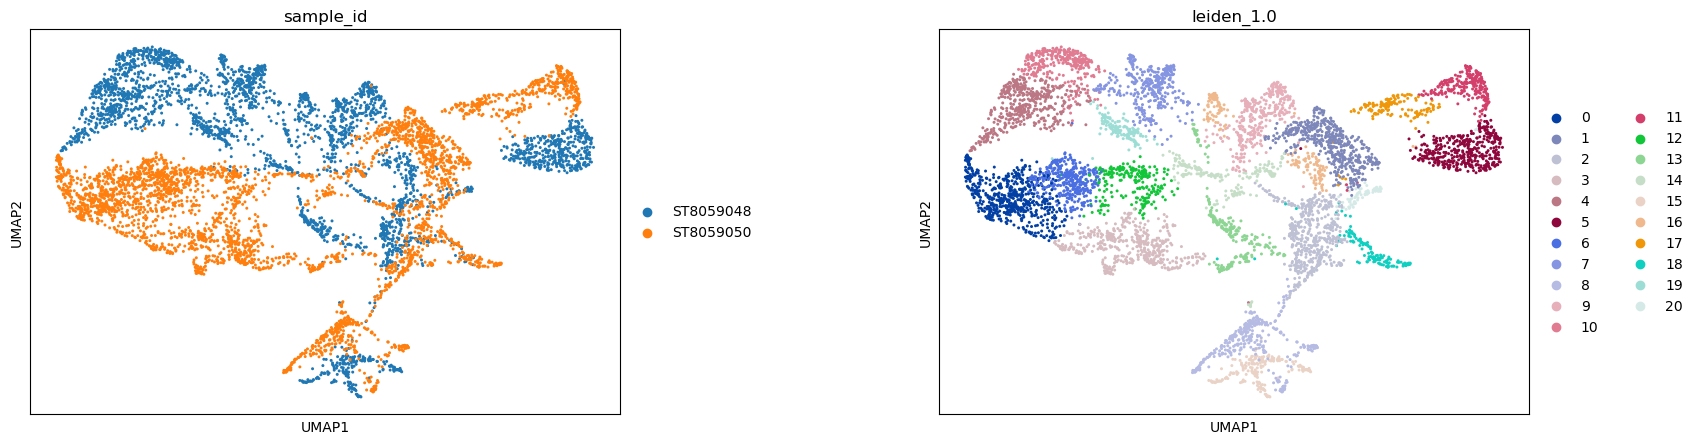

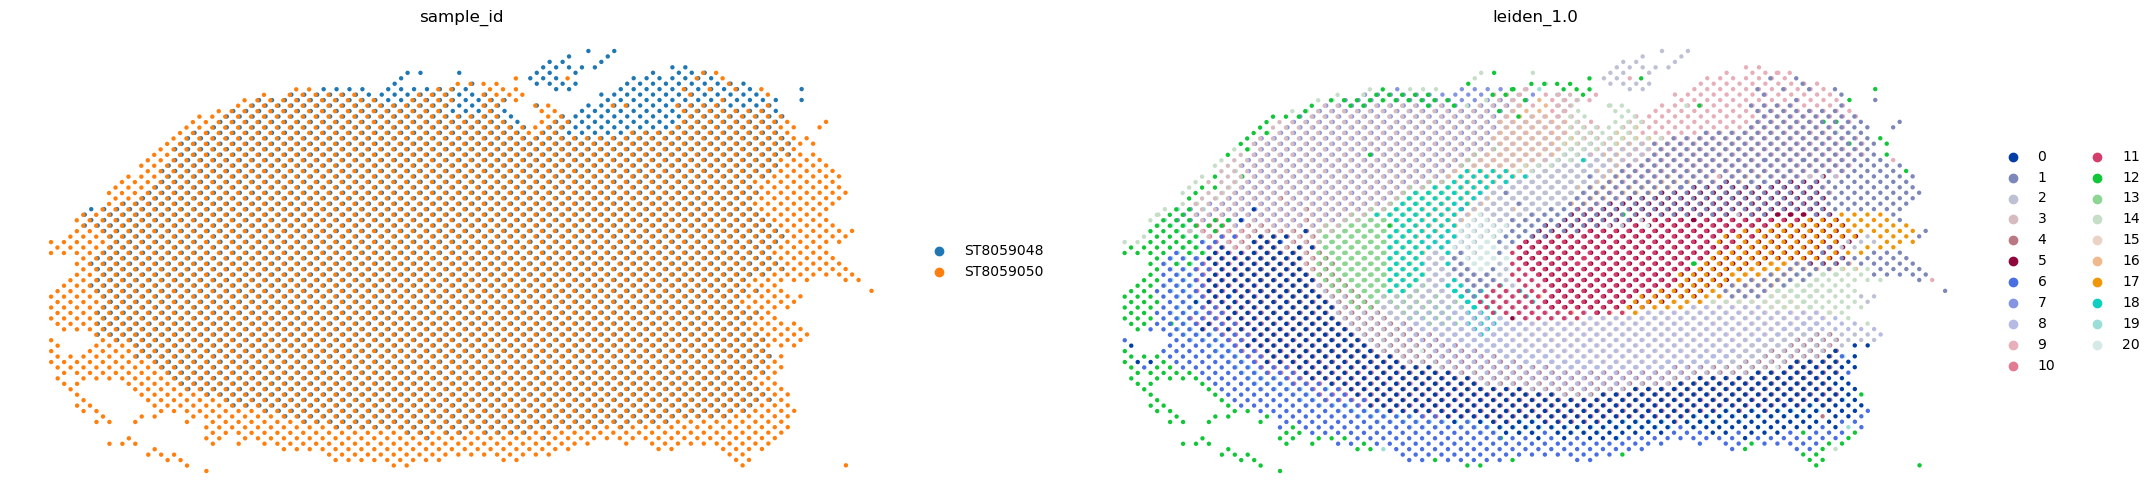

In [14]:
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.umap(adata, color=["sample_id", "leiden_1.0"], wspace=0.4)

with plt.rc_context({"figure.figsize": (12, 6)}):
    sc.pl.embedding(adata, basis="spatial", color=["sample_id", "leiden_1.0"], s=40, frameon=False)


In [25]:
import squidpy as sq
import cellcharter as cc

In [24]:
sq.gr.spatial_neighbors(adata, library_key='sample_id', coord_type='grid', delaunay=True)

In [26]:
cc.gr.remove_long_links(adata)

## Optional Save

Run the next cell if you want a processed `h5ad` written next to the extracted SpatialData cache.


In [27]:
OUTPUT_H5AD = EXTRACT_ROOT / f"{Path(ZIP_PATH).stem}_{TABLE_NAME}.processed.h5ad"
adata.write_h5ad(OUTPUT_H5AD)
OUTPUT_H5AD

PosixPath('/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_spatialdata_0_7_1/visium_spatialdata_0.7.1_table.processed.h5ad')

In [ ]:
adata

AnnData object with n_obs × n_vars = 6484 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_1.0'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatialdata_attrs', 'spatialdata_source', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_1.0', 'sample_id_colors', 'leiden_1.0_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Optional inspection

Use the next cell to inspect a specific table in detail. This is especially useful for the Visium HD archive, which contains multiple tables.

In [ ]:
table_name = TABLE_NAME
table = adata

print(table_name)
print(table)
table.obs.head()